<a href="https://colab.research.google.com/github/ni-metre/Colab_Triplet_Loss_Backup/blob/master/km3v2_EXTRAPOLATE_IntendedTempGroup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Set up gspread
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())
% xmode verbose

Exception reporting mode: Verbose


In [2]:
#Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#To remoount drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
# Load the Pandas libraries with alias 'pd' 
import sys
import os
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
import math
import random
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D

from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
import bokeh.io
from bokeh.models import ColumnDataSource, HoverTool, Label, TextAreaInput
from bokeh.models.tools import HoverTool
from bokeh.palettes import viridis, Turbo256
from bokeh.transform import factor_cmap


### Reading in the Test_Log of real data (**test_db_df**)to create a record of fake data (**fake_test_db_df**)

In [10]:
#Define folder for outputs (and make it if it doesn't exist)
sensor_of_interest = 43
base_dir_name = '2V3_Fakes_CO2/'
real_src = 'General'

descriptor = '2V3_Fake_ML_Fake_CO2_Extrapolate_Age_TotalCO2_'+ str(sensor_of_interest) 
logname = 'Fake_Test_Log_for_' + descriptor + '.csv'
base_path = '/content/drive/My Drive/' + base_dir_name
output_path = base_path + descriptor 

if not os.path.exists(output_path):
    os.makedirs(output_path)

In [11]:

#Run this to define import function, which gets called in each plotting function (in case Test_Log is updated)
def do_import():
  wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1xHVjmlRynUE6YYZFh8rvOuFd7Mb-eWHIIwvsTvndFkY/edit?usp=sharing')
  sheet = wb.worksheet('Test_Log_ML_Filled')
  test_data = sheet.get_all_values()
  test_df = pd.DataFrame(test_data)
  test_df.columns = test_df.iloc[0]
  test_df  = test_df .iloc[1:]
  test_df['Sensor']= test_df['Sensor'].replace("?", 0)
  test_df['File']= test_df['File'].astype('int32')
  for column in test_df[['Acetone', 'CO2', 'H2O', 'Sensor','File', 'Test_that_day', 'Time_Btwn_s', 'Instr_Temp', 'Baseline', 'Total_CO2', 'New_Baseline', 'Sample_rate', 'CO2_measured', 'adj_co2' ]]:
      test_df[column] = pd.to_numeric(test_df[column])
  test_db_df = test_df.set_index('File')
  return(test_db_df)
  
#Check that Test_Log looks okay
test_db_df = do_import()
test_db_df.fillna(0, inplace= True)
test_db_df.head()

,Raw_data,Test_name,H2O,CO2,Total_CO2,CO2_measured,adj_co2,co2_baseline,Acetone,Sample_rate,Gain,Gain_Adj,Instr,Sensor,Instr_Temp,Date,Time,Time_Btwn_s,Test_that_day,FLAG,Notes,Data_pts,Baseline,Amb_Temp,Other,Rel_Hum,EtOH_temp,Instr_T2,Instr_T3,New_Baseline,Baseline_Dip,Peak_neg,Peak_pos,Peak_neg_t,Peak_pos_t,Cross_t,Cross_t_ix,Peak_neg_t_ix,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,Area_total_X,Area_pos,Area_total,Area_pos_8,Area_pos_16,,ML_Pred_CO2,ML_Pred_Ac
File,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3000,wav3000,Nitrogen blank,0,0,0.0,0,0.0,,0.0,250,,,38107,7,0.0,2020-02-11,1:53:44 PM,50024.0,1,,,8076,26.770204,0,0.00,0.00,0,,,26.0,-0.84,-2.495264403,34.0613,18.4200,1.32,0.00,0,1842.00000,132,0.00,-1060.00,0.00,0.00,0,2.67,0,0,0,,,
3001,wav3000,Nitrogen blank,0,0,0.0,0,0.0,,0.0,250,,,38263,6,0.0,2020-02-11,1:54:02 PM,50042.0,1,,,6253,25.223295,0,0.00,0.00,0,,,25.0,0.0446,-3.68,4.53E+01,10.3000,1.14E+00,0.00,0.00E+00,1030.00000,1.14E+02,0.00,1737.00,0.00,0.00,0,18.17,0,0,0,,,
3002,wav3001,Nitrogen blank,0,0,0.0,0,0.0,,0.0,250,,,38107,7,0.0,2020-02-11,1:56:27 PM,163.0,2,,,5380,26.311880,0,0.00,0.00,0,,,26.0,0.0605,-2.476566964,38.7806,18.0500,1.27,0.00,0,1805.00000,127,0.00,5373.00,0.00,0.00,0,62.95,0,0,0,,,
3003,wav3001,Nitrogen blank,0,0,0.0,0,0.0,,0.0,250,,,38263,6,0.0,2020-02-11,1:56:36 PM,154.0,2,,,4455,25.250096,0,0.00,0.00,0,,,25.0,-0.0134,-3.71,4.56E+01,11.8000,1.15E+00,0.00,0.00E+00,1180.00000,1.15E+02,0.00,5217.00,0.00,0.00,0,51.52,0,0,0,,,
3004,wav3002,Nitrogen blank,0,0,0.0,0,0.0,,0.0,250,,,38107,7,0.0,2020-02-11,2:04:19 PM,472.0,3,,,4184,26.724979,0,0.00,0.00,0,,,27.0,0.1782,-2.078048257,32.9568,18.1300,1.29,0.00,0,1813.00000,129,0.00,6489.00,0.00,0.00,0,72.46,0,0,0,,,


In [12]:
fake_test_db_df = pd.DataFrame(test_db_df.loc[test_db_df['Sensor'] == sensor_of_interest])
fake_test_db_df.head(-1)


,Raw_data,Test_name,H2O,CO2,Total_CO2,CO2_measured,adj_co2,co2_baseline,Acetone,Sample_rate,Gain,Gain_Adj,Instr,Sensor,Instr_Temp,Date,Time,Time_Btwn_s,Test_that_day,FLAG,Notes,Data_pts,Baseline,Amb_Temp,Other,Rel_Hum,EtOH_temp,Instr_T2,Instr_T3,New_Baseline,Baseline_Dip,Peak_neg,Peak_pos,Peak_neg_t,Peak_pos_t,Cross_t,Cross_t_ix,Peak_neg_t_ix,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,Area_total_X,Area_pos,Area_total,Area_pos_8,Area_pos_16,,ML_Pred_CO2,ML_Pred_Ac
File,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20007,jdata20007,3% CO2 through plain water,10,30000,0.00000,25455,0.0,,0.00,250,695.0,1.0,112,43,26.2400,2021-05-12,10:22:49 AM,10000.0,1,,,11975,23.201456,,,29.58,,,,0.0,,-47.92676875,4.22073125,1.7440,12.044,7.43,1421,436,3011,,,-163,,,0,-163.2050561,,,,25455.112,0.6140000224
20016,jdata20016,3% CO2 through plain water,10,30000,0.25527,25527,0.0,,0.00,250,695.0,1.0,112,43,27.3500,2021-05-12,10:32:24 AM,575.0,2,,,11976,23.493656,,,28.20,,,,0.0,,-48.29490625,4.32884375,1.7480,11.664,7.38,1409,437,2916,,,-163,,,0,-163.2568054,,,,25527.418,0.6700000167
20025,jdata20025,5% CO2 through plain water,10,50000,0.65145,39618,0.0,,0.00,250,695.0,1.0,112,43,26.7400,2021-05-12,10:41:51 AM,567.0,3,,,11976,23.594462,,,31.48,,,,0.0,,-77.3894625,6.79335,1.7960,12,7.45,1413,449,3000,,,-263,,,0,-263.4050983,,,,39617.733,-1.388000011
20034,jdata20034,5% CO2 through plain water,10,50000,1.05880,40735,0.0,,0.00,250,695.0,1.0,112,43,25.4600,2021-05-12,10:50:57 AM,546.0,4,,,11975,23.540050,,,33.59,,,,0.0,,-79.2884875,6.8890125,1.7960,11.724,7.47,1419,449,2931,,,-270,,,0,-270.9010113,,,,40735.443,-1.537999988
20043,jdata20043,3% CO2 through 6.25 ppm acetone,10,30000,1.31020,25140,0.0,,6.25,250,695.0,1.0,112,43,24.8300,2021-05-12,11:00:13 AM,556.0,5,,,11975,23.543569,,,34.96,,,,0.0,,-49.24013125,5.94799375,1.7040,11.252,6.82,1280,426,2813,,,-158,,,0,-158.2125495,,,,25139.519,5.531000137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20988,jdata20988,4% CO2 through plain water,10,40000,59.68946,39146,0.0,2077,0.00,250,695.0,,112,43,23.0041,2021-06-11,10:42:23 AM,549.0,2,,,14987,23.367531,,,39.83,,,,0.0,,-75.15096875,7.14246875,2.1120,13.024,8.30,1547,528,3256,,,-288,,,0,-288.3124821,,,,44500.343,0.7220000029
20992,jdata20992,3% CO2 through 6.25 ppm acetone,10,30000,60.02853,33907,0.0,0,6.25,250,695.0,,112,43,23.4295,2021-06-11,10:51:21 AM,538.0,3,X,Simulator not heted,14987,23.543356,,,38.83,,,,0.0,,-61.12460625,6.32320625,2.1120,12.728,8.11,1500,528,3182,,,-229,,,0,-229.59053,,,,,
20996,jdata20996,3% CO2 through 6.25 ppm acetone,10,30000,60.35700,32847,0.0,3437,6.25,250,695.0,,112,43,23.9549,2021-06-11,11:04:26 AM,785.0,4,,,14987,23.778350,,,37.89,,,,0.0,,-62.1196,7.077275,2.0440,12.636,7.88,1460,511,3159,,,-229,,,0,-229.462024,,,,35764.629,5.672999859


In [13]:
# Run this cell to exclude additional tests


# Run this cell to exclude additional tests
#fake_test_db_df = fake_test_db_df.truncate(before = 20612)
#test_db_df = test_db_df.truncate(before = 20612)

fake_test_db_df = fake_test_db_df.truncate(after = 20983)
test_db_df = test_db_df.truncate(after = 20983)


In [14]:
FIRST_REAL = int(fake_test_db_df.index[0])
LAST_REAL = int(fake_test_db_df.index[-1])
STARTNUM = LAST_REAL +1
print('length of df', len(fake_test_db_df))
print('first real number ', FIRST_REAL)
print('last real number ', LAST_REAL)
print('fake data starting number' , STARTNUM)

length of df 161
first real number  20007
last real number  20980
fake data starting number 20981


# Test List Defs

In [15]:
#Returns a list of tests that meet ALL of the criteria defined in the arguments
# Acetone can be a specific value, 'all', '>(value)' or '<(value)'
# CO2 can be a specific value, 'all' or '+' for CO@ values that are > 0
# H2O must be a specific value, almost always 10 for tests of interest
# Sensor can be a specific sensor number or 'all'
# Range1/2 is the lower and upper limit for the range of tests of interest from range1 to rang2 - 1

def get_test_list (df, Acetone, CO2, H2O, Sensor, Range1, Range2):

    if Sensor == 'all':
        filtered = df
    else:
        filtered = df[(df['Sensor'] == Sensor)]
    filtered = filtered.query('FLAG ==""')
    if Acetone != 'all':
        if str(Acetone)[:1] == '<':
            filtered = filtered[filtered['Acetone'].astype(float) < float(Acetone[1:])]
        else:
            if str(Acetone)[:1] == '>':
                filtered = filtered[filtered['Acetone'].astype(float) > float(Acetone[1:])]
            else:
                filtered = filtered[(filtered['Acetone'] == Acetone)]
    if CO2 != 'all':
        if CO2 == '+':
            filtered = filtered[(filtered['CO2'] != '0')]
        else:
            filtered = filtered[(filtered['CO2'] == CO2)]
    filtered = filtered[(filtered['H2O'] == H2O)]
    filtered['Tests'] = filtered.index  
    list_of_tests = filtered['Tests'].tolist()
    return([y for y in list_of_tests if ((int(y)>=Range1)&(int(y)<Range2))])
#Returns a list of tests that meet ALL of the criteria defined in the arguments
# SAME AS get_test_list above for the following
# Acetone can be a specific value, 'all', '>(value)' or '<(value)'
# CO2 can be a specific value, 'all' or '+' for CO@ values that are > 0
# H2O must be a specific value, almost always 10 for tests of interest
# Sensor can be a specific sensor number or 'all'
# Range1/2 is the lower and upper limit for the range of tests of interest from range1 to rang2 - 1
#BUT
# temp is a temperature value in degrees C
# and delta is range in degrees C above and below temp that will be included in the returned list

def get_test_list_Temp (df, Acetone, CO2, H2O, temp, delta, Sensor, Range1, Range2):

    if Sensor == 'all':
        filtered = df
    else:
        filtered = df[(df['Sensor'] == Sensor)]
    filtered = filtered.query('FLAG ==""')
    if Acetone != 'all':
        if str(Acetone)[:1] == '<':
            filtered = filtered[filtered['Acetone'].astype(float) < float(Acetone[1:])]
        else:
            if str(Acetone)[:1] == '>':
                filtered = filtered[filtered['Acetone'].astype(float) > float(Acetone[1:])]
            else:
                filtered = filtered[(filtered['Acetone'] == Acetone)]
    if CO2 != 'all':
        if CO2 == '+':
            filtered = filtered[(filtered['CO2'] != '0')]
        else:
            filtered = filtered[(filtered['CO2'] == CO2)]
    filtered = filtered[(filtered['H2O'] == H2O)]
    filtered['Tests'] = filtered.index
    filtered['Instr_Temp'] = pd.to_numeric(filtered['Instr_Temp'])
    filtered = filtered[filtered['Instr_Temp']>= temp - delta]
    filtered = filtered[filtered['Instr_Temp']<= temp + delta]
    list_of_tests = filtered['Tests'].tolist()
    return([y for y in list_of_tests if ((int(y)>=Range1)&(int(y)<Range2))])

def make_db_from_get_test_list (df, Acetone, CO2, H2O, Sensor, Range1, Range2):
    
    if Sensor == 'all':
        filtered = df
    else:
        filtered = df.query('Sensor == @Sensor')
    if Acetone != 'all':
        if str(Acetone)[:1] == '<':
            comp = float(Acetone[1:])
            filtered = filtered.query('Acetone < @comp')
        else:
            if str(Acetone)[:1] == '>':
                comp = float(Acetone[1:])
                filtered = filtered.query('Acetone > @comp')
            else:
                filtered = filtered.query('Acetone == @Acetone')
    if CO2 != 'all':
        if CO2 == '+':
            filtered = filtered.query('CO2 != 0')
        else:
            if CO2 == 4:
                filtered = filtered.query('CO2 >= 40000 & CO2 <= 46666.67')
            else:
                if CO2 == 5:
                    filtered = filtered.query('CO2 > 46666.67 & CO2 <= 53333.33')
                else:
                    filtered = filtered.query('CO2 > 53333.33 & CO2 <= 60000')
    filtered = filtered.query('H2O == @H2O')
    filtered['Tests'] = filtered.index  
    list_of_tests = filtered['Tests'].tolist()
    new_df = filtered.loc[filtered.index > Range1]
    new_df = new_df.loc[new_df.index < Range2]
    return(filtered)

#######################
def get_test_temp_list (df, Acetone, ac_delta, CO2, H2O, temp, t_delta, Sensor, Range1, Range2):
    
    if Sensor == 'all':
        filtered = df
    else:
        filtered = df.query('Sensor == @Sensor')
    if Acetone != 'all':
        if str(Acetone)[:1] == '<':
            comp = float(Acetone[1:])
            filtered = filtered.query('Acetone < @comp')
        else:
            if str(Acetone)[:1] == '>':
                comp = float(Acetone[1:])
                filtered = filtered.query('Acetone > @comp')
            else:
                filtered = filtered[filtered['Acetone']>= Acetone - ac_delta]
                filtered = filtered[filtered['Acetone']<= Acetone + ac_delta]
    if CO2 != 'all':
        if CO2 == '+':
            filtered = filtered.query('CO2 != 0')
        else:
            if CO2 == 4:
                filtered = filtered.query('CO2 >= 40000 & CO2 <= 46666.67')
            else:
                if CO2 == 5:
                    filtered = filtered.query('CO2 > 46666.67 & CO2 <= 53333.33')
                else:
                    filtered = filtered.query('CO2 > 53333.33 & CO2 <= 60000')


    filtered = filtered[filtered['Instr_Temp']>= temp - t_delta]
    filtered = filtered[filtered['Instr_Temp']<= temp + t_delta]
    filtered = filtered.query('H2O == @H2O')
    filtered['Tests'] = filtered.index  
    list_of_tests = filtered['Tests'].tolist()
    return([y for y in list_of_tests if ((int(y)>=Range1)&(int(y)<Range2))])

# Defining Functions for grid method of generating fake data

In [16]:
def make_new_fake_real_metadata(signal,num):

    fake_test_db_df.loc[num, 'Data_pts'] = len(signal)
    sample_rate = 250
    peak_pos = signal['mV_rolling_mean'].max()
    peak_pos_t_ix = signal['mV_rolling_mean'].idxmax()
    peak_pos_t = signal.loc[peak_pos_t_ix,'Second']
    fake_test_db_df.loc[num, 'Peak_pos'] = peak_pos
    fake_test_db_df.loc[num, 'Peak_pos_t'] = peak_pos_t
    fake_test_db_df.loc[num, 'Peak_pos_t_ix'] = peak_pos_t_ix
    peak_neg = signal['mV_rolling_mean'].min()
    peak_neg_t_ix = signal['mV_rolling_mean'].idxmin()
    peak_neg_t = signal.loc[peak_neg_t_ix,'Second']
    fake_test_db_df.loc[num, 'Peak_neg'] = peak_neg
    fake_test_db_df.loc[num, 'Peak_neg_t'] = peak_neg_t
    fake_test_db_df.loc[num, 'Peak_neg_t_ix'] = peak_neg_t_ix
    
    pos_data = signal.truncate(before=peak_neg_t_ix, axis=None)
# find x-point --- first trim all negative data
    cross_t_ix = (pos_data['mV_rolling_mean'] >= 0).idxmax()
# get time at x-point
    cross_t = pos_data.loc[cross_t_ix,'Second']
    
    fake_test_db_df.loc[num, 'Cross_t'] = cross_t
    fake_test_db_df.loc[num, 'Cross_t_ix'] = cross_t_ix
        
# get positive area
    pos_data = signal.truncate(before = cross_t_ix)
    pk_8th = peak_pos/8
    pk_16th = peak_pos/16
    tail_data = signal.truncate(before=peak_pos_t_ix)
    last_pt = pos_data['mV_rolling_mean'].values[-1]
    if last_pt < pk_16th:
        pk_16th_t_ix = (tail_data['mV_rolling_mean'] <= pk_16th).idxmax()
        pos_data_16 = pos_data.truncate(after = pk_16th_t_ix)
        area_pos_16 = int(pos_data_16['mV_rolling_mean'].sum())
        fake_test_db_df.loc[num, 'Area_pos_16'] = int(area_pos_16/sample_rate)
#Exclude these calculations for short tests
    if last_pt < pk_8th:
        pk_8th_t_ix = (tail_data['mV_rolling_mean'] <= pk_8th).idxmax()
        pos_data_8 = pos_data.truncate(after = pk_8th_t_ix)
        area_pos_8 = int(pos_data_8['mV_rolling_mean'].sum())
        fake_test_db_df.loc[num, 'Area_pos_8'] = int(area_pos_8/sample_rate)
        area_pos = int(area_pos_8/sample_rate)*1.27-173
        fake_test_db_df.loc[num, 'Area_pos'] = area_pos
    else:
        area_pos = 0
        fake_test_db_df.loc[num, 'Area_pos'] = area_pos
# get Negative area      
    neg_data = signal.truncate(after = cross_t_ix)
    area_neg = int(neg_data['mV_rolling_mean'].sum()) 
    fake_test_db_df.loc[num, 'Area_neg'] = int(area_neg/sample_rate)
# post total area
    fake_test_db_df.loc[num, 'Area_total'] = area_neg + area_pos
    return fake_test_db_df
    


In [17]:
###Assumes that tests have the same sample rate
def make_a_fake_test_string(test1, test2, filenum, howmany,fake_test_db_df):
    print(test1, test2, filenum)
    new_tests = [test1]
    root_path_1a = output_path + '/test_output' + str(test1) + '.csv'
    root_path_1b ='/content/drive/My Drive/Test_outputs/' + real_src + '/test_output' + str(test1) + '.csv'
    root_path_2a = output_path + '/test_output' + str(test2) + '.csv'
    root_path_2b ='/content/drive/My Drive/Test_outputs/' + real_src + '/test_output' + str(test2) + '.csv'
  
    if os.path.exists(root_path_1a):
      signal1 = pd.read_csv(root_path_1a)
    else:
      signal1 = pd.read_csv(root_path_1b)

    if os.path.exists(root_path_2a):
      signal2 = pd.read_csv(root_path_2a)
    else:
      signal2 = pd.read_csv(root_path_2b)

    len1 = len(signal1.index)
    len2 = len(signal2.index)
    if len1 > len2:
        signal1 = signal1.truncate(after=len2)
    else:
        signal2 = signal2.truncate(after=len1)
    fake_signal = signal2.copy()

    tc1 = float(fake_test_db_df.loc[test1, 'Total_CO2'])
    tc2 = float(fake_test_db_df.loc[test2, 'Total_CO2'])
    if tc2 >= tc2:
      interval = 1/(howmany + 1) #max weight is 1; make numerator 0.5 to change
    else:
      interval = (tc1/tc2)/(howmany + 1)
    for i in range(howmany):
        weight = interval * (i+1)
        fake_signal['mV_rolling_mean'] = signal1['mV_rolling_mean']+((signal2['mV_rolling_mean']-signal1['mV_rolling_mean'])*-weight)
        fake_signal.to_csv(output_path + '/test_output' + str(filenum) + '.csv', index=False, columns=['Second', 'mV_rolling_mean'])
        fake_test_db_df = write_fake_real_metadata(test1, test2, weight, filenum, fake_test_db_df)
        fake_test_db_df = make_new_fake_real_metadata(fake_signal,filenum)
        new_tests.append(filenum)
        filenum = filenum + 1
    # This writes to test log
    fake_test_db_df.to_csv(base_path + '/' + logname)
    new_tests.append(test2)
    return(new_tests,filenum)
    

In [18]:
def write_fake_real_metadata(test1, test2, weight, num, fake_test_db_df):

    param_list = ['CO2', 'Total_CO2', 'Acetone', 'Time_Btwn_s', 'Test_that_day', 'Instr_Temp', 'Baseline', 'New_Baseline', 'CO2_measured', 'co2_baseline']
    for param in param_list:
        fake_test_db_df[param] = pd.to_numeric(fake_test_db_df[param])
    fake_test_db_df.loc[num, 'File_num'] = num
    fake_test_db_df.loc[num, 'Instr'] = fake_test_db_df.loc[test1, 'Instr']
    fake_test_db_df.loc[num, 'Sensor'] = fake_test_db_df.loc[test1, 'Sensor']
    fake_test_db_df.loc[num, 'Sample_rate'] = 250
    fake_test_db_df.loc[num, 'H2O'] = fake_test_db_df.loc[test1, 'H2O']

    fake_test_db_df.loc[num, 'Test_name'] = 'Combo of ' + str(test1) + ' and ' + str(test2) + ' | Weight - ' + str(weight)
    fake_test_db_df.loc[num, 'CO2'] = (fake_test_db_df.loc[test1, 'CO2']) + (((fake_test_db_df.loc[test2, 'CO2']) - (fake_test_db_df.loc[test1, 'CO2']))*weight)
    fake_test_db_df.loc[num, 'Total_CO2'] = (fake_test_db_df.loc[test1, 'Total_CO2']) + (((fake_test_db_df.loc[test2, 'Total_CO2']) - (fake_test_db_df.loc[test1, 'Total_CO2']))*-weight)
    fake_test_db_df.loc[num, 'Acetone'] = (fake_test_db_df.loc[test1, 'Acetone']) + (((fake_test_db_df.loc[test2, 'Acetone']) - (fake_test_db_df.loc[test1, 'Acetone']))*weight)
    fake_test_db_df.loc[num, 'Time_Btwn_s'] = (fake_test_db_df.loc[test1, 'Time_Btwn_s']) + (((fake_test_db_df.loc[test2, 'Time_Btwn_s']) - (fake_test_db_df.loc[test1, 'Time_Btwn_s']))*weight)
    fake_test_db_df.loc[num, 'Test_that_day'] = (fake_test_db_df.loc[test1, 'Test_that_day']) + (((fake_test_db_df.loc[test2, 'Test_that_day']) - (fake_test_db_df.loc[test1, 'Test_that_day']))*weight)
    fake_test_db_df.loc[num, 'Instr_Temp'] = (fake_test_db_df.loc[test1, 'Instr_Temp']) + (((fake_test_db_df.loc[test2, 'Instr_Temp']) - (fake_test_db_df.loc[test1, 'Instr_Temp']))*weight)
    fake_test_db_df.loc[num, 'Baseline'] = (fake_test_db_df.loc[test1, 'Baseline']) + (((fake_test_db_df.loc[test2, 'Baseline']) - (fake_test_db_df.loc[test1, 'Baseline']))*weight)
    fake_test_db_df.loc[num, 'New_Baseline'] = (fake_test_db_df.loc[test1, 'New_Baseline']) + (((fake_test_db_df.loc[test2, 'New_Baseline']) - (fake_test_db_df.loc[test1, 'New_Baseline']))*weight)
    fake_test_db_df.loc[num, 'CO2_measured'] = (fake_test_db_df.loc[test1, 'CO2_measured']) + (((fake_test_db_df.loc[test2, 'CO2_measured']) - (fake_test_db_df.loc[test1, 'CO2_measured']))*weight)
    #fake_test_db_df.loc[num, 'co2_baseline'] = (fake_test_db_df.loc[test1, 'co2_baseline']) + (((fake_test_db_df.loc[test2, 'co2_baseline']) - (fake_test_db_df.loc[test1, 'co2_baseline']))*weight)

    
    return fake_test_db_df


In [31]:
foo = random.uniform(0.1, -100)
print(foo)

-49.70908832651525


# Defining functions for random weight (i.e. non-grid) method of generating fake data

In [19]:
###Assumes that tests have the same sample rate
def make_rand_weight_fake_test(test1, test2, how_many,filenum):
    sample_rate1 = test_db_df.loc[test1, 'Sample_rate']
    sample_rate2 = test_db_df.loc[test2, 'Sample_rate']
    signal1 = pd.read_csv('/content/drive/My Drive/Test_outputs/' + real_src + '/test_output' + str(test1) + '.csv')
    signal2 = pd.read_csv('/content/drive/My Drive/Test_outputs/' + real_src + '/test_output' + str(test2) + '.csv')
    mV1 = np.array(signal1['mV_rolling_mean'])
    mV2 = np.array(signal2['mV_rolling_mean'])
    s1 =  np.array(signal1['Second'])
    s2 =  np.array(signal2['Second'])
###########
    if sample_rate1 == 500:
      if (len(mV1) %2) ==0:
        pass
      else: 
        mV1 = mV1[:-1]
        s1 = s1[:-1]
      mV1 = mV1.reshape(-1, 2).mean(axis=1)
      s1 = s1[::2]
    else:
      pass
    if sample_rate2 == 500:
      if (len(mV2) %2) ==0:
        pass
      else:
        mV2 = mV2[:-1]
        s2 = s2[:-1]
      mV2 = mV2.reshape(-1, 2).mean(axis=1)
      s2 =s2[::2]
    else:
      pass
    len1 = len(s1)
    len2 = len(s2)    
    if len1 > len2:
        s1 = s1[:len2]
        mV1 = mV1[:len2]
    else:
        s2 = s2[:len1]
        mV2 = mV2[:len1]    
    tc1 = float(fake_test_db_df.loc[test1, 'Total_CO2'])
    tc2 = float(fake_test_db_df.loc[test2, 'Total_CO2'])
    if tc2 >= tc1:
      maxweight = 99
    else:
      maxweight = tc1/(tc2-tc1)

    ########
    for i in range(how_many):
      if maxweight <= 1:
        weight = random.uniform(0.1, maxweight)/100
      elif maxweight <= how_many:
        weight = random.uniform(0.1, maxweight)/100
      else:
        weight = random.uniform(1, int(maxweight))/100
      fake_mV = mV1 +((mV2-mV1)*-weight)
      fake_signal = pd.DataFrame({"Second": s1, "mV_rolling_mean":fake_mV}) 
      fake_signal.to_csv(output_path + '/test_output' + str(filenum) + '.csv', index=False, columns=['Second', 'mV_rolling_mean'])
      #### str(filenum) might be a problem
      write_rand_weight_meta_data(test1, test2, weight, filenum)
      make_rand_weight_new_metadata(fake_signal,filenum)
      filenum = filenum + 1

In [20]:
def make_rand_weight_new_metadata(signal,num):
    
    fake_test_db_df.loc[num, 'Data_pts'] = len(signal)
    sample_rate = 250
    peak_pos = signal['mV_rolling_mean'].max()
    peak_pos_t_ix = signal['mV_rolling_mean'].idxmax()
    peak_pos_t = signal.loc[peak_pos_t_ix, 'Second']
    fake_test_db_df.loc[num, 'Peak_pos'] = peak_pos
    fake_test_db_df.loc[num, 'Peak_pos_t'] = peak_pos_t
    fake_test_db_df.loc[num, 'Peak_pos_t_ix'] = peak_pos_t_ix
    peak_neg = signal['mV_rolling_mean'].min()
    peak_neg_t_ix = signal['mV_rolling_mean'].idxmin()
    peak_neg_t = signal.loc[peak_neg_t_ix, 'Second']
    fake_test_db_df.loc[num, 'Peak_neg'] = peak_neg
    fake_test_db_df.loc[num, 'Peak_neg_t'] = peak_neg_t
    fake_test_db_df.loc[num, 'Peak_neg_t_ix'] = peak_neg_t_ix
    pos_data = signal.truncate(before=peak_neg_t_ix, axis=None)
# find x-point --- first trim all negative data
    cross_t_ix = (pos_data['mV_rolling_mean'] >= 0).idxmax()
# get time at x-point
    cross_t = pos_data.loc[cross_t_ix, 'Second']
    fake_test_db_df.loc[num, 'Cross_t'] = cross_t
    fake_test_db_df.loc[num, 'Cross_t_ix'] = cross_t_ix 
# get positive area
    pos_data = signal.truncate(before = cross_t_ix)
    pk_8th = peak_pos/8
    pk_16th = peak_pos/16
    tail_data = signal.truncate(before=peak_pos_t_ix)
    last_pt = pos_data['mV_rolling_mean'].values[-1]
    if last_pt < pk_16th:
        pk_16th_t_ix = (tail_data['mV_rolling_mean'] <= pk_16th).idxmax()
        pos_data_16 = pos_data.truncate(after = pk_16th_t_ix)
        area_pos_16 = int(pos_data_16['mV_rolling_mean'].sum())
        fake_test_db_df.loc[num, 'Area_pos_16'] = int(area_pos_16/sample_rate)
#Exclude these calculations for short tests
    if last_pt < pk_8th:
        pk_8th_t_ix = (tail_data['mV_rolling_mean'] <= pk_8th).idxmax()
        pos_data_8 = pos_data.truncate(after = pk_8th_t_ix)
        area_pos_8 = int(pos_data_8['mV_rolling_mean'].sum())
        fake_test_db_df.loc[num, 'Area_pos_8'] = int(area_pos_8/sample_rate)
        area_pos = int(area_pos_8/sample_rate)*1.27-173
        fake_test_db_df.loc[num, 'Area_pos'] = area_pos
    else:
        area_pos = 0
        fake_test_db_df.loc[num, 'Area_pos'] = area_pos
# get Negative area      
    neg_data = signal.truncate(after = cross_t_ix)
    area_neg = int(neg_data['mV_rolling_mean'].sum()) 
    fake_test_db_df.loc[num, 'Area_neg'] = int(area_neg/sample_rate)
# post total area
    fake_test_db_df.loc[num, 'Area_total'] = area_neg + area_pos
    
   

In [21]:
def write_rand_weight_meta_data(test1, test2, weight, num):
    # This is here bc tests start at 10,000
    param_list = ['CO2', 'Total_CO2', 'Acetone', 'Time_Btwn_s', 'Test_that_day', 'Instr_Temp', 'Baseline', 'New_Baseline', 'Sample_rate', 'CO2_measured', 'co2_baseline']
    for param in param_list:
        fake_test_db_df[param] = pd.to_numeric(fake_test_db_df[param])
    fake_test_db_df.loc[num, 'Instr'] = test_db_df.loc[test1, 'Instr']
    fake_test_db_df.loc[num, 'Sensor'] = test_db_df.loc[test1, 'Sensor']
    fake_test_db_df.loc[num, 'Sample_rate'] = 250
    fake_test_db_df.loc[num, 'H2O'] = test_db_df.loc[test1, 'H2O']
    fake_test_db_df.loc[num, 'Test_name'] = 'Combo of ' + str(test1) + ' and ' + str(test2) + ' | Weight - ' + str(weight)
    fake_test_db_df.loc[num, 'CO2'] = float(test_db_df.loc[test1, 'CO2']) + ((float(test_db_df.loc[test2, 'CO2']) - float(test_db_df.loc[test1, 'CO2']))*weight)
    fake_test_db_df.loc[num, 'Total_CO2'] = float(test_db_df.loc[test1, 'Total_CO2']) + ((float(test_db_df.loc[test2, 'Total_CO2']) - float(test_db_df.loc[test1, 'Total_CO2']))*-weight)
    fake_test_db_df.loc[num, 'Acetone'] = float(test_db_df.loc[test1, 'Acetone']) + ((float(test_db_df.loc[test2, 'Acetone']) - float(test_db_df.loc[test1, 'Acetone']))*weight)
    fake_test_db_df.loc[num, 'Time_Btwn_s'] = float(test_db_df.loc[test1, 'Time_Btwn_s']) + ((float(test_db_df.loc[test2, 'Time_Btwn_s']) - float(test_db_df.loc[test1, 'Time_Btwn_s']))*weight)
    fake_test_db_df.loc[num, 'Test_that_day'] = float(test_db_df.loc[test1, 'Test_that_day']) + ((float(test_db_df.loc[test2, 'Test_that_day']) - float(test_db_df.loc[test1, 'Test_that_day']))*weight)
    fake_test_db_df.loc[num, 'Instr_Temp'] = float(test_db_df.loc[test1, 'Instr_Temp']) + ((float(test_db_df.loc[test2, 'Instr_Temp']) - float(test_db_df.loc[test1, 'Instr_Temp']))*weight)
    fake_test_db_df.loc[num, 'Baseline'] = float(test_db_df.loc[test1, 'Baseline']) + ((float(test_db_df.loc[test2, 'Baseline']) - float(test_db_df.loc[test1, 'Baseline']))*weight)
    fake_test_db_df.loc[num, 'New_Baseline'] = float(test_db_df.loc[test1, 'New_Baseline']) + ((float(test_db_df.loc[test2, 'New_Baseline']) - float(test_db_df.loc[test1, 'New_Baseline']))*weight)
    fake_test_db_df.loc[num, 'CO2_measured'] = float(test_db_df.loc[test1, 'CO2_measured']) + ((float(test_db_df.loc[test2, 'CO2_measured']) - float(test_db_df.loc[test1, 'CO2_measured']))*weight)
    #fake_test_db_df.loc[num, 'co2_baseline'] = float(test_db_df.loc[test1, 'co2_baseline']) + ((float(test_db_df.loc[test2, 'co2_baseline']) - float(test_db_df.loc[test1, 'co2_baseline']))*weight)

# Grid method for first half of data generation

In [22]:
FIRST_REAL0 = 20000
LAST_REAL0 = 20611

In [23]:
def make_grid(low_ac, med_ac, high_ac, fake_test_db_df, fill):
  mll0 = get_test_list_Temp (fake_test_db_df, low_ac, 30000, 10, 27, 3, sensor_of_interest,  20000, 20612)
  mll1 = get_test_list_Temp (fake_test_db_df, low_ac, 30000, 10, 24, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  mll = mll0 + mll1
  print(mll)
  mlm0 = get_test_list_Temp (fake_test_db_df, low_ac, 40000, 10, 27, 3, sensor_of_interest, FIRST_REAL0, LAST_REAL0+1)
  mlm1 = get_test_list_Temp (fake_test_db_df, low_ac, 40000, 10, 24, 5, sensor_of_interest, FIRST_REAL, LAST_REAL+1)
  mlm = mlm0 + mlm1
  print(mlm)
  mlh0 = get_test_list_Temp (fake_test_db_df, low_ac, 50000, 10, 27, 3, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  mlh1 = get_test_list_Temp (fake_test_db_df, low_ac, 50000, 10, 24, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  mlh = mlh0 + mlh1
  print(mlh)

  mml0 = get_test_list_Temp (fake_test_db_df, med_ac, 30000, 10, 27, 3, sensor_of_interest, FIRST_REAL0, LAST_REAL0+1)
  mml1 = get_test_list_Temp (fake_test_db_df, med_ac, 30000, 10, 24, 5, sensor_of_interest, FIRST_REAL, LAST_REAL+1)
  mml = mml0 + mml1
  print(mml)
  mmm0 = get_test_list_Temp (fake_test_db_df, med_ac, 40000, 10, 27, 3, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  mmm1 = get_test_list_Temp (fake_test_db_df, med_ac, 40000, 10, 24, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  mmm = mmm0 + mmm1
  print(mmm)
  mmh0 = get_test_list_Temp (fake_test_db_df, med_ac, 50000, 10, 27, 3, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  mmh1 = get_test_list_Temp (fake_test_db_df, med_ac, 50000, 10, 24, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  mmh = mmh0 + mmh1
  print(mmh)

  mhl0 = get_test_list_Temp (fake_test_db_df, high_ac, 30000, 10,27, 3, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  mhl1 = get_test_list_Temp (fake_test_db_df, high_ac, 30000, 10, 24, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  mhl = mhl0 + mhl1
  print(mhl)
  mhm0 = get_test_list_Temp (fake_test_db_df, high_ac, 40000, 10, 27, 3, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  mhm1 = get_test_list_Temp (fake_test_db_df, high_ac, 40000, 10, 24, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  mhm = mhm0 + mhm1
  print(mhm)
  mhh0 = get_test_list_Temp (fake_test_db_df, high_ac, 50000, 10, 27, 3, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  mhh1 = get_test_list_Temp (fake_test_db_df, high_ac, 50000, 10, 24, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  mhh = mhh0 + mhh1

  print(mhh)

  ###########
  lll0 = get_test_list_Temp (fake_test_db_df, low_ac, 30000, 10, 20, 3.7, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  lll1 = get_test_list_Temp (fake_test_db_df, low_ac, 30000, 10, 13, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  lll = lll0 + lll1
  print(lll)
  llm0 = get_test_list_Temp (fake_test_db_df, low_ac, 40000, 10, 20, 3.7, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  llm1 = get_test_list_Temp (fake_test_db_df, low_ac, 40000, 10, 13, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  llm = llm0 + llm1
  print(llm)
  llh0 = get_test_list_Temp (fake_test_db_df, low_ac, 50000, 10, 20, 3.7, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  llh1 = get_test_list_Temp (fake_test_db_df, low_ac, 50000, 10, 13, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  llh = llh0 + llh1
  print(llh)

  lml0 = get_test_list_Temp (fake_test_db_df, med_ac, 30000, 10, 20, 3.7, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  lml1 = get_test_list_Temp (fake_test_db_df, med_ac, 30000, 10, 13, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  lml = lml0 + lml1
  print(lml)
  lmm0 = get_test_list_Temp (fake_test_db_df, med_ac, 40000, 10, 20, 3.7, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  lmm1 = get_test_list_Temp (fake_test_db_df, med_ac, 40000, 10, 13, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  lmm = lmm0 + lmm1
  print(lmm)
  lmh0 = get_test_list_Temp (fake_test_db_df, med_ac, 50000, 10, 20, 3.7, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  lmh1 = get_test_list_Temp (fake_test_db_df, med_ac, 50000, 10, 13, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  lmh = lmh0 + lmh1
  print(lmh)

  lhl0 = get_test_list_Temp (fake_test_db_df, high_ac, 30000, 10, 20, 3.7, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  lhl1 = get_test_list_Temp (fake_test_db_df, high_ac, 30000, 10, 13, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  lhl = lhl0 + lhl1
  print(lhl)
  lhm0 = get_test_list_Temp (fake_test_db_df, high_ac, 40000, 10, 20, 3.7, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  lhm1 = get_test_list_Temp (fake_test_db_df, high_ac, 40000, 10, 13, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  lhm = lhm0 + lhm1
  print(lhm)
  lhh0 = get_test_list_Temp (fake_test_db_df, high_ac, 50000, 10, 20, 3.7, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  lhh1 = get_test_list_Temp (fake_test_db_df, high_ac, 50000, 10, 13, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  lhh = lhh0 + lhh1
  print(lhh)

  ###########
  hll0 = get_test_list_Temp (fake_test_db_df, low_ac, 30000, 10, 40, 3, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  hll1 = get_test_list_Temp (fake_test_db_df, low_ac, 30000, 10, 35, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  hll = hll0 + hll1
  print(hll)
  hlm0 = get_test_list_Temp (fake_test_db_df, low_ac, 40000, 10, 40, 3, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  hlm1 = get_test_list_Temp (fake_test_db_df, low_ac, 40000, 10, 35, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  hlm = hlm0 + hlm1
  print(hlm)
  hlh0 = get_test_list_Temp (fake_test_db_df, low_ac, 50000, 10, 40, 3, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  hlh1 = get_test_list_Temp (fake_test_db_df, low_ac, 50000, 10, 35, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  hlh = hlh0 + hlh1
  print(hlh)

  hml0 = get_test_list_Temp (fake_test_db_df, med_ac, 30000, 10, 40, 3, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  hml1 = get_test_list_Temp (fake_test_db_df, med_ac, 30000, 10, 35, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  hml = hml0 + hml1
  print(hml)
  hmm0 = get_test_list_Temp (fake_test_db_df, med_ac, 40000, 10, 40, 3, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  hmm1 = get_test_list_Temp (fake_test_db_df, med_ac, 40000, 10, 35, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  hmm = hmm0 + hmm1
  print(hmm)
  hmh0 = get_test_list_Temp (fake_test_db_df, med_ac, 50000, 10, 40, 3, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  hmh1 = get_test_list_Temp (fake_test_db_df, med_ac, 50000, 10, 35, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  hmh = hmh0 + hmh1
  print(hmh)

  hhl0 = get_test_list_Temp (fake_test_db_df, high_ac, 30000, 10, 40, 3, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  hhl1 = get_test_list_Temp (fake_test_db_df, high_ac, 30000, 10, 35, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  hhl = hhl0 + hhl1
  print(hhl)
  hhm0 = get_test_list_Temp (fake_test_db_df, high_ac, 40000, 10, 40, 3, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  hhm1 = get_test_list_Temp (fake_test_db_df, high_ac, 40000, 10, 35, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  hhm = hhm0 + hhm1
  print(hhm)
  hhh0 = get_test_list_Temp (fake_test_db_df, high_ac, 50000, 10,40, 3, sensor_of_interest,  FIRST_REAL0, LAST_REAL0+1)
  hhh1 = get_test_list_Temp (fake_test_db_df, high_ac, 50000, 10, 35, 5, sensor_of_interest,  FIRST_REAL, LAST_REAL+1)
  hhh = hhh0 + hhh1
  print(hhh)
  print(len(fake_test_db_df))
  STARTNUM = int(fake_test_db_df.index[-1]) +1
  print(STARTNUM)

  ### WITH MEDIUM TEMPERATURE AND MEDIUM ACETONE AND MEDIUM CO2 REAL DATA
  ### fill should be an even number

  start_file_num = STARTNUM

  try:
    ll1,next_num = make_a_fake_test_string(random.choice(lll), random.choice(llm), start_file_num, int(fill), fake_test_db_df)
    ll2,next_num = make_a_fake_test_string(random.choice(llm), random.choice(llh), next_num, int(fill/2), fake_test_db_df)
    ll = ll1 + ll2[1:]
    print(ll)
  except (IndexError, NameError):
    pass
  try:
    lh1,next_num = make_a_fake_test_string(random.choice(lhl), random.choice(lhm), next_num, int(fill), fake_test_db_df)
    lh2,next_num = make_a_fake_test_string(random.choice(lhm), random.choice(lhh), next_num, int(fill), fake_test_db_df)
    lh = lh1 + lh2[1:]
    print(lh)
  except (IndexError, NameError):
    pass
  try:
    ml1,next_num = make_a_fake_test_string(random.choice(mll), random.choice(mlm), next_num, int(fill), fake_test_db_df)
    ml2,next_num = make_a_fake_test_string(random.choice(mlm), random.choice(mlh), next_num, int(fill), fake_test_db_df)
    ml = ml1 + ml2[1:]
    print(ml)
  except (IndexError, NameError):
    pass
  try:
    mh1,next_num = make_a_fake_test_string(random.choice(mhl), random.choice(mhm), next_num, int(fill), fake_test_db_df)
    mh2,next_num = make_a_fake_test_string(random.choice(mhm), random.choice(mhh), next_num, int(fill), fake_test_db_df)
    mh = mh1 + mh2[1:]
    print(mh)
  except (IndexError, NameError):
    pass
  try:
    hl1,next_num = make_a_fake_test_string(random.choice(hll), random.choice(hlm), next_num, int(fill), fake_test_db_df)
    hl2,next_num = make_a_fake_test_string(random.choice(hlm), random.choice(hlh), next_num, int(fill), fake_test_db_df)
    hl = hl1 + hl2[1:]
    print(hl)
  except (IndexError, NameError):
    pass
  try:
    hh1,next_num = make_a_fake_test_string(random.choice(hhl), random.choice(hhm), next_num, int(fill), fake_test_db_df)
    hh2,next_num = make_a_fake_test_string(random.choice(hhm), random.choice(hhh), next_num, int(fill), fake_test_db_df)
    hh = hh1 + hh2[1:]
    print(hh)
  except (IndexError, NameError):
    pass
  try:
    lm1,next_num = make_a_fake_test_string(random.choice(lml), random.choice(lmm), next_num, int(fill), fake_test_db_df)
    lm2,next_num = make_a_fake_test_string(random.choice(lmm), random.choice(lmh), next_num, int(fill), fake_test_db_df)
    lm = lm1 + lm2[1:]
    print(lm)
  except (IndexError, NameError):
    pass
  try:
    hm1,next_num = make_a_fake_test_string(random.choice(hml), random.choice(hmm), next_num, int(fill), fake_test_db_df)
    hm2,next_num = make_a_fake_test_string(random.choice(hmm), random.choice(hmh), next_num, int(fill), fake_test_db_df)
    hm = hm1 + hm2[1:]
    print(hm)
  except (IndexError, NameError):
    pass
  try:
    mm1,next_num = make_a_fake_test_string(random.choice(mml), random.choice(mmm), next_num, int(fill), fake_test_db_df)
    mm2,next_num = make_a_fake_test_string(random.choice(mmm), random.choice(mmh), next_num, int(fill), fake_test_db_df)
    mm = mm1 + mm2[1:]
    print(mm)
  except (IndexError, NameError):
    pass


  for i in range(len(ll)):
    try:
      l1,next_num = make_a_fake_test_string(ll[i],lm[i],next_num,int(fill/2), fake_test_db_df)
    except (IndexError, NameError):
      pass
    try:
      l2,next_num = make_a_fake_test_string(lm[i],lh[i],next_num,int(fill/2), fake_test_db_df)
    except (IndexError, NameError):
      pass
    try:
      m1,next_num = make_a_fake_test_string(ml[i],mm[i],next_num,int(fill/2), fake_test_db_df)
    except (IndexError, NameError):
      pass 
    try:
      m2,next_num = make_a_fake_test_string(mm[i],mh[i],next_num,int(fill/2), fake_test_db_df)
    except (IndexError, NameError):
      pass
    try:
      h1,next_num = make_a_fake_test_string(hl[i],hm[i],next_num,int(fill/2), fake_test_db_df)
    except (IndexError, NameError):
      pass
    try:
      h2,next_num = make_a_fake_test_string(hm[i],hh[i],next_num,int(fill/2), fake_test_db_df)
    except (IndexError, NameError):
      pass
    try:
      l = l1 + l2[1:]
    except (IndexError, NameError):
      pass
    try:
      m = m1 + m2[1:]
    except (IndexError, NameError):
      pass
    try:
      h = h1 + h2[1:]
    except (IndexError, NameError):
      pass
    print(l)
    print(m)
    print(h)
    for j in range(len(l)):
      try:
        l_m,next_num = make_a_fake_test_string(l[j],m[j],next_num,int(fill/2), fake_test_db_df)
      except (IndexError, NameError):
        pass
      try:
         m_h,next_num = make_a_fake_test_string(m[j],h[j],next_num,int(fill/2), fake_test_db_df)
         print(l_m)
         print(m_h)
      except (IndexError, NameError):
         pass
  return fake_test_db_df

In [24]:
fake_test_db_df = make_grid(0, 6.25, 12.5, fake_test_db_df, 16)
fake_test_db_df = make_grid( 12.5, 25 ,50, fake_test_db_df, 18)

Streaming output truncated to the last 5000 lines.
[21638, 21845, 21846, 21847, 21848, 21849, 21850, 21851, 21852, 21654]
21623 21639 21853
21639 21655 21861
[21623, 21853, 21854, 21855, 21856, 21857, 21858, 21859, 21860, 21639]
[21639, 21861, 21862, 21863, 21864, 21865, 21866, 21867, 21868, 21655]
21624 21640 21869
21640 21656 21877
[21624, 21869, 21870, 21871, 21872, 21873, 21874, 21875, 21876, 21640]
[21640, 21877, 21878, 21879, 21880, 21881, 21882, 21883, 21884, 21656]
21625 21641 21885
21641 21657 21893
[21625, 21885, 21886, 21887, 21888, 21889, 21890, 21891, 21892, 21641]
[21641, 21893, 21894, 21895, 21896, 21897, 21898, 21899, 21900, 21657]
21626 21642 21901
21642 21658 21909
[21626, 21901, 21902, 21903, 21904, 21905, 21906, 21907, 21908, 21642]
[21642, 21909, 21910, 21911, 21912, 21913, 21914, 21915, 21916, 21658]
21627 21643 21917
21643 21659 21925
[21627, 21917, 21918, 21919, 21920, 21921, 21922, 21923, 21924, 21643]
[21643, 21925, 21926, 21927, 21928, 21929, 21930, 21931, 21

# Random Fill Method for Fake Dta Generation

In [25]:
t0 = get_test_list_Temp(test_db_df,'all',30000,10,13,5,sensor_of_interest,FIRST_REAL,LAST_REAL+1) + get_test_list_Temp(test_db_df,'all',30000,10,20, 3.7,sensor_of_interest,FIRST_REAL0,LAST_REAL0+1) #0
t1 = get_test_list_Temp(test_db_df,'all',40000,10,13,5,sensor_of_interest,FIRST_REAL,LAST_REAL+1) + get_test_list_Temp(test_db_df,'all',40000,10,20, 3.7,sensor_of_interest,FIRST_REAL0,LAST_REAL0+1) #1
t2 = get_test_list_Temp(test_db_df,'all',50000,10,13,5,sensor_of_interest,FIRST_REAL,LAST_REAL+1) + get_test_list_Temp(test_db_df,'all',50000,10,20, 3.7,sensor_of_interest,FIRST_REAL0,LAST_REAL0+1) #2
t3 = get_test_list_Temp(test_db_df,'all',30000,10,24,5,sensor_of_interest,FIRST_REAL,LAST_REAL+1) + get_test_list_Temp(test_db_df,'all',30000,10,27, 3.0,sensor_of_interest,FIRST_REAL0,LAST_REAL0+1) #3
t4 = get_test_list_Temp(test_db_df,'all',40000,10,24,5,sensor_of_interest,FIRST_REAL,LAST_REAL+1) + get_test_list_Temp(test_db_df,'all',40000,10,27, 3.0,sensor_of_interest,FIRST_REAL0,LAST_REAL0+1) #4
t5 = get_test_list_Temp(test_db_df,'all',50000,10,24,5,sensor_of_interest,FIRST_REAL,LAST_REAL+1) + get_test_list_Temp(test_db_df,'all',50000,10,27, 3.0,sensor_of_interest,FIRST_REAL0,LAST_REAL0+1) #5
t6 = get_test_list_Temp(test_db_df,'all',30000,10,35,5,sensor_of_interest,FIRST_REAL,LAST_REAL+1) + get_test_list_Temp(test_db_df,'all',30000,10,40, 3.0,sensor_of_interest,FIRST_REAL0,LAST_REAL0+1) #6
t7 = get_test_list_Temp(test_db_df,'all',40000,10,35,5,sensor_of_interest,FIRST_REAL,LAST_REAL+1) + get_test_list_Temp(test_db_df,'all',40000,10,40, 3.0,sensor_of_interest,FIRST_REAL0,LAST_REAL0+1) #7
t8 = get_test_list_Temp(test_db_df,'all',50000,10,35,5,sensor_of_interest,FIRST_REAL,LAST_REAL+1) + get_test_list_Temp(test_db_df,'all',50000,10,40, 3.0,sensor_of_interest,FIRST_REAL0,LAST_REAL0+1) #8                                                                                                                   
                                                                                                                    

In [26]:
neighbors = ([1,3,4],[3,4,5],[1,4,5],[1,4,7],[0,2,6,8],
             [1,4,7],[3,4,7],[3,4,5],[4,5,7])
all_tests_9_group_all = [t0, t1, t2, t3, t4, t5, t6, t7, t8]
print(len(all_tests_9_group_all[0]))
print(len(all_tests_9_group_all[0]))
fullist = [0, 1, 2, 3, 4, 5, 6, 7, 8]
STARTNUM2 = fake_test_db_df.index[-1]
print(STARTNUM2)

23
23
44039


In [27]:
# one run will yield ≈ 28 fake tests
# should run at least 20 times to get coverage of the space
#global fake_test_db_df

STARTNUM2 = fake_test_db_df.index[-1]
fake_test_num = STARTNUM2+1

repeats = 200
test_db_dfx =test_db_df.copy()
test_db_dfx.reset_index(inplace = True)

s_array = test_db_dfx[['File', 'Acetone']].to_numpy(dtype='float')
f_array = s_array[::, 0]

for z in range(repeats):

    test_group = random.choice(fullist)
    test_1 = random.choice(all_tests_9_group_all[test_group])
    file_index = np.where(f_array == float(test_1))[0][0]
    t1_ace = s_array[file_index,1]
    test_2_group_list = neighbors[test_group]
    print('test1 ' + str(test_1) + ' ace-' + str(t1_ace))
    while True:

        test_2 = random.choice(all_tests_9_group_all[test_group])
        file_index = np.where(f_array == float(test_2))[0][0]
        t2_ace = s_array[file_index,1]
        if (float(t2_ace) < 2 * t1_ace + 6.5) and  (float(t2_ace) > t1_ace/2 - 6.5) and (float(t2_ace) != t1_ace):
            break

    test_2_list = [test_2]
    for i in test_2_group_list:
        while True:

            test_2 = random.choice(all_tests_9_group_all[i])
            file_index = np.where(f_array == float(test_2))[0][0]
            t2_ace = s_array[file_index,1]
            if (float(t2_ace) < 2 * t1_ace + 6.5) and  (float(t2_ace) > t1_ace/2 - 6.5) and (float(t2_ace)):
                break

        test_2_list.append(test_2)
    print(test_2_list)
    for t in test_2_list:
        num_of_fakes = random.choice([5,7,11,13])
        make_rand_weight_fake_test(test_1, t, num_of_fakes, fake_test_num)
        fake_test_num = fake_test_num + num_of_fakes

    fake_test_db_df.to_csv(base_path + '/' + logname)

fake_test_db_df.head()

test1 20796 ace-12.5
[20752, 20052, 20696, 20652]
test1 20916 ace-12.5
[20368, 20900, 20124, 20648]
test1 20868 ace-0.0
[20602, 20900, 20640, 20644]
test1 20820 ace-25.0
[20848, 20151, 20728, 20704]
test1 20852 ace-50.0
[20824, 20160, 20724, 20503]
test1 20732 ace-50.0
[20494, 20944, 20728, 20824]
test1 20728 ace-50.0
[20696, 20485, 20494, 20341, 20350]
test1 20512 ace-50.0
[20476, 20968, 20696, 20848]
test1 20115 ace-25.0
[20664, 20944, 20648, 20820]
test1 20124 ace-25.0
[20088, 20972, 20724, 20820]
test1 20593 ace-6.25
[20079, 20900, 20648, 20800]
test1 20151 ace-50.0
[20115, 20968, 20720, 20824]
test1 20332 ace-50.0
[20296, 20548, 20696, 20828]
test1 20602 ace-6.25
[20449, 20900, 20648, 20776]
test1 20016 ace-0.0
[20593, 20900, 20644, 20772]
test1 20215 ace-0.0
[20242, 20648, 20422, 20776]
test1 20720 ace-50.0
[20696, 20548, 20530, 20816, 20359]
test1 20980 ace-50.0
[20494, 20972, 20696, 20142]
test1 20964 ace-50.0
[20936, 20944, 20160, 20728]
test1 20188 ace-0.0
[20224, 20052, 2064

,Raw_data,Test_name,H2O,CO2,Total_CO2,CO2_measured,adj_co2,co2_baseline,Acetone,Sample_rate,Gain,Gain_Adj,Instr,Sensor,Instr_Temp,Date,Time,Time_Btwn_s,Test_that_day,FLAG,Notes,Data_pts,Baseline,Amb_Temp,Other,Rel_Hum,EtOH_temp,Instr_T2,Instr_T3,New_Baseline,Baseline_Dip,Peak_neg,Peak_pos,Peak_neg_t,Peak_pos_t,Cross_t,Cross_t_ix,Peak_neg_t_ix,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,Area_total_X,Area_pos,Area_total,Area_pos_8,Area_pos_16,,ML_Pred_CO2,ML_Pred_Ac,File_num
File,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20007,jdata20007,3% CO2 through plain water,10.0,30000.0,0.00000,25455.0,0.0,NaN,0.00,250.0,695.0,1.0,112,43.0,26.24,2021-05-12,10:22:49 AM,10000.0,1.0,,,11975,23.201456,,,29.58,,,,0.0,,-47.92676875,4.22073125,1.7440,12.044,7.43,1421,436,3011,,,-163,,,0,-163.2050561,,,,25455.112,0.6140000224,NaN
20016,jdata20016,3% CO2 through plain water,10.0,30000.0,0.25527,25527.0,0.0,NaN,0.00,250.0,695.0,1.0,112,43.0,27.35,2021-05-12,10:32:24 AM,575.0,2.0,,,11976,23.493656,,,28.20,,,,0.0,,-48.29490625,4.32884375,1.7480,11.664,7.38,1409,437,2916,,,-163,,,0,-163.2568054,,,,25527.418,0.6700000167,NaN
20025,jdata20025,5% CO2 through plain water,10.0,50000.0,0.65145,39618.0,0.0,NaN,0.00,250.0,695.0,1.0,112,43.0,26.74,2021-05-12,10:41:51 AM,567.0,3.0,,,11976,23.594462,,,31.48,,,,0.0,,-77.3894625,6.79335,1.7960,12,7.45,1413,449,3000,,,-263,,,0,-263.4050983,,,,39617.733,-1.388000011,NaN
20034,jdata20034,5% CO2 through plain water,10.0,50000.0,1.05880,40735.0,0.0,NaN,0.00,250.0,695.0,1.0,112,43.0,25.46,2021-05-12,10:50:57 AM,546.0,4.0,,,11975,23.540050,,,33.59,,,,0.0,,-79.2884875,6.8890125,1.7960,11.724,7.47,1419,449,2931,,,-270,,,0,-270.9010113,,,,40735.443,-1.537999988,NaN
20043,jdata20043,3% CO2 through 6.25 ppm acetone,10.0,30000.0,1.31020,25140.0,0.0,NaN,6.25,250.0,695.0,1.0,112,43.0,24.83,2021-05-12,11:00:13 AM,556.0,5.0,,,11975,23.543569,,,34.96,,,,0.0,,-49.24013125,5.94799375,1.7040,11.252,6.82,1280,426,2813,,,-158,,,0,-158.2125495,,,,25139.519,5.531000137,NaN


# Check density of generated tests


30737


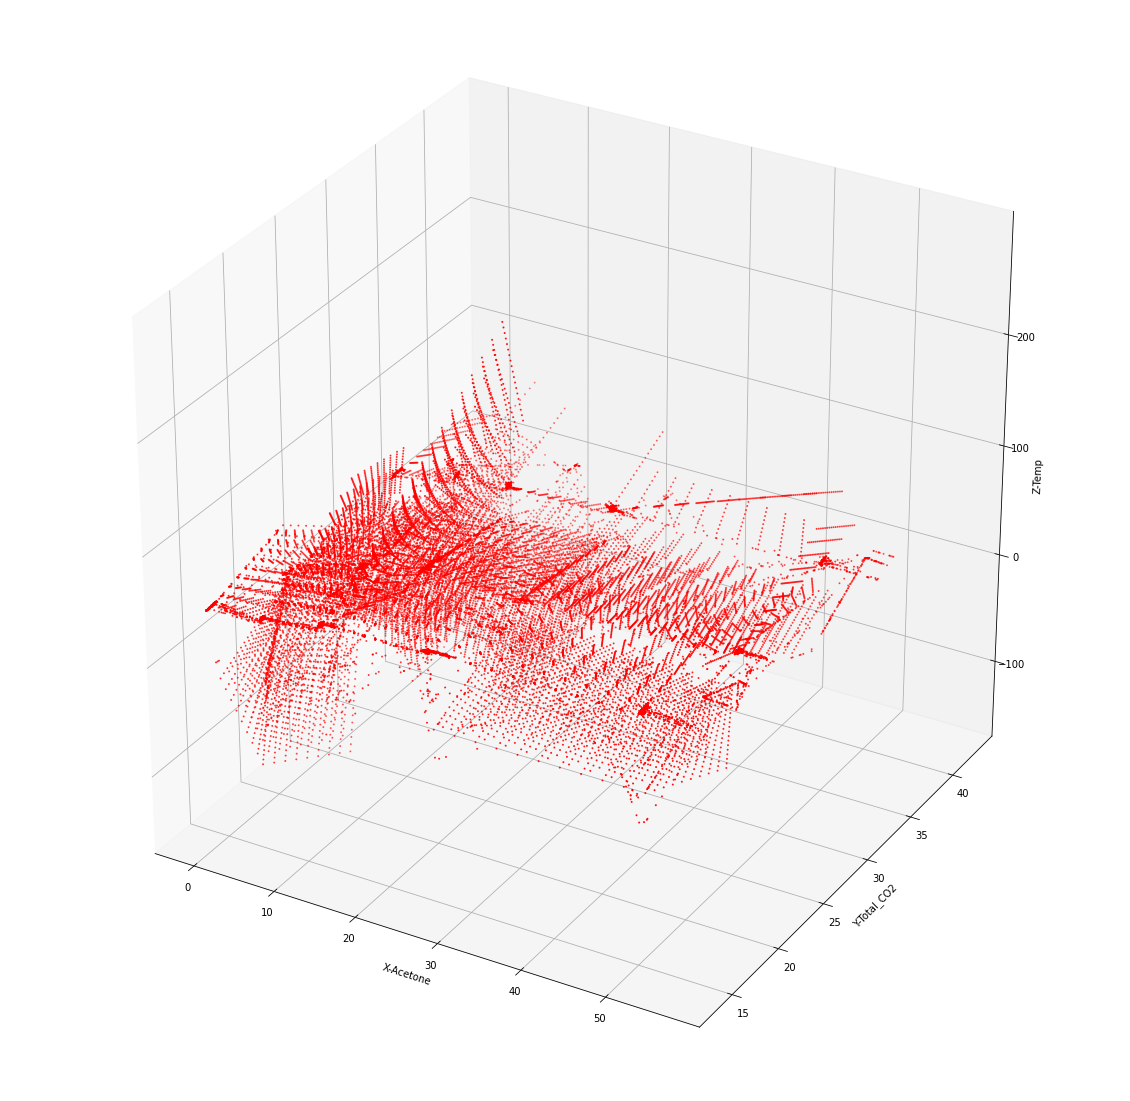

30737


In [29]:
db = fake_test_db_df
print(len(db))
#plot points and fitted surface
X= db['Acetone']
Y =db['Total_CO2']
Z =db['Instr_Temp']

# plot points and fitted surface
fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection='3d')
#ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(X, Z, Y, c='r', s=1)
plt.xlabel('X-Acetone')
plt.ylabel('Y-Total_CO2')
ax.set_zlabel('Z-Temp')
ax.axis('tight')
plt.show()
print(len(db))

Text(0, 0.5, 'Total CO2')

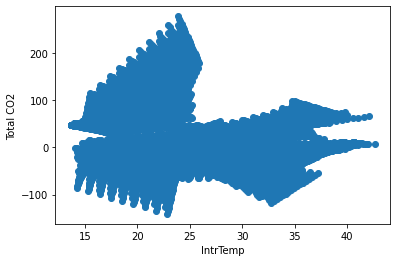

In [30]:
plt.figure()
plt.scatter(Z, Y)
plt.xlabel('IntrTemp')
plt.ylabel('Total CO2')

In [ ]:
timelist = []
mVlist = []
labellist = []

test_list = get_test_temp_list(fake_test_db_df, 12.5, 0.5 , 5, 10, 26, 0.2, sensor_of_interest,LAST_REAL+1,100000)
print(len(test_list))

real_test_list = get_test_temp_list(fake_test_db_df, 12.5, 0.5 , 5, 10, 25, 5, sensor_of_interest, FIRST_REAL, LAST_REAL+1)
print(len(real_test_list))

plt.figure(figsize=(20,10))
for filenum in test_list[:5]:
  instr_temp = fake_test_db_df.loc[filenum, 'Instr_Temp']
  ac_val = fake_test_db_df.loc[filenum, 'Acetone']
  co2_val = fake_test_db_df.loc[filenum, 'CO2']
  peak_neg = fake_test_db_df.loc[filenum, 'Peak_neg']
  test_data = pd.read_csv(output_path + '/test_output'+ str(int(filenum)) + '.csv')
  test_label = str(filenum) + ', acetone = ' + str(round(ac_val, 3)) + ', co2 = ' + str(round(co2_val, 0)) + ' instr_temp = ' + str(round(instr_temp,1)) + ' peak neg = ' + str(round(float(peak_neg),2))
  plt.plot(test_data['Second'], test_data['mV_rolling_mean'], label = test_label)
  timelist.append(test_data['Second'])
  mVlist.append(test_data['mV_rolling_mean'])
  labellist.append(test_label)
for filenum in real_test_list:
  instr_temp = fake_test_db_df.loc[filenum, 'Instr_Temp']
  ac_val = fake_test_db_df.loc[filenum, 'Acetone']
  co2_val = fake_test_db_df.loc[filenum, 'CO2']
  peak_neg = fake_test_db_df.loc[filenum, 'Peak_neg']
  path_1 = output_path + '/test_output'+ str(int(filenum)) + '.csv'
  path_2 = '/content/drive/My Drive/Test_outputs/' + real_src + '/test_output' + str(int(filenum)) + '.csv'
  if os.path.exists(path_1):
    test_data = pd.read_csv(path_1)
  else:
    test_data = pd.read_csv(path_2)
  test_label = str(filenum) + ', acetone = ' + str(round(ac_val, 3)) + ', co2 = ' + str(round(co2_val, 0)) + ' instr_temp = ' + str(round(instr_temp,1)) + ' peak neg = ' + str(round(float(peak_neg),2))
  plt.plot(test_data['Second'], test_data['mV_rolling_mean'] , label = test_label, c= 'k')
  timelist.append(test_data['Second'])
  mVlist.append(test_data['mV_rolling_mean'])
  labellist.append(test_label)
plt.plot()
plt.legend()
plt.show()
print('The last test in fake_test_db_df is ', int(fake_test_db_df.index[-1]))

In [ ]:
def bplot_label(x_list, y_list, llist):
    xs_list = []
    ys_list = []
    label_list = []
    for val in x_list:
        xs_list.append(val)
    for val in llist:
        label_list.append(val)
    for val in y_list:
        ys_list.append(val)

    color_list= viridis(len(x_list))
    multi_data = {'xs': xs_list,
                 'ys': ys_list,
                  'labels': label_list,

                 'color': color_list}
    multi_source = ColumnDataSource(multi_data)
    q = figure(plot_width=1300, plot_height=800,toolbar_location = "left",
              x_axis_label = "xval",
              y_axis_label = "yval")
    q.multi_line(xs='xs', ys='ys', legend_group= 'labels', color = 'color', source=multi_source)

    q.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
        ('data', '@labels'),
        ('x_value', '$x'),
        ('y_value', '$y')
        ]))

    q.border_fill_color = "white"
    q.min_border_left = 200
    output_notebook()
    show(q)
bplot_label(timelist, mVlist, labellist)

In [28]:
fake_test_db_df.head(-1)

,Raw_data,Test_name,H2O,CO2,Total_CO2,CO2_measured,adj_co2,co2_baseline,Acetone,Sample_rate,Gain,Gain_Adj,Instr,Sensor,Instr_Temp,Date,Time,Time_Btwn_s,Test_that_day,FLAG,Notes,Data_pts,Baseline,Amb_Temp,Other,Rel_Hum,EtOH_temp,Instr_T2,Instr_T3,New_Baseline,Baseline_Dip,Peak_neg,Peak_pos,Peak_neg_t,Peak_pos_t,Cross_t,Cross_t_ix,Peak_neg_t_ix,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,Area_total_X,Area_pos,Area_total,Area_pos_8,Area_pos_16,,ML_Pred_CO2,ML_Pred_Ac,File_num
File,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20007,jdata20007,3% CO2 through plain water,10.0,30000.000000,0.000000,25455.000000,0.0,NaN,0.00,250.0,695.0,1.0,112,43.0,26.240000,2021-05-12,10:22:49 AM,10000.000000,1.000000,,,11975,23.201456,,,29.58,,,,0.0,,-47.92676875,4.22073125,1.7440,12.044,7.43,1421,436,3011,,,-163,,,0,-163.2050561,,,,25455.112,0.6140000224,NaN
20016,jdata20016,3% CO2 through plain water,10.0,30000.000000,0.255270,25527.000000,0.0,NaN,0.00,250.0,695.0,1.0,112,43.0,27.350000,2021-05-12,10:32:24 AM,575.000000,2.000000,,,11976,23.493656,,,28.20,,,,0.0,,-48.29490625,4.32884375,1.7480,11.664,7.38,1409,437,2916,,,-163,,,0,-163.2568054,,,,25527.418,0.6700000167,NaN
20025,jdata20025,5% CO2 through plain water,10.0,50000.000000,0.651450,39618.000000,0.0,NaN,0.00,250.0,695.0,1.0,112,43.0,26.740000,2021-05-12,10:41:51 AM,567.000000,3.000000,,,11976,23.594462,,,31.48,,,,0.0,,-77.3894625,6.79335,1.7960,12,7.45,1413,449,3000,,,-263,,,0,-263.4050983,,,,39617.733,-1.388000011,NaN
20034,jdata20034,5% CO2 through plain water,10.0,50000.000000,1.058800,40735.000000,0.0,NaN,0.00,250.0,695.0,1.0,112,43.0,25.460000,2021-05-12,10:50:57 AM,546.000000,4.000000,,,11975,23.540050,,,33.59,,,,0.0,,-79.2884875,6.8890125,1.7960,11.724,7.47,1419,449,2931,,,-270,,,0,-270.9010113,,,,40735.443,-1.537999988,NaN
20043,jdata20043,3% CO2 through 6.25 ppm acetone,10.0,30000.000000,1.310200,25140.000000,0.0,NaN,6.25,250.0,695.0,1.0,112,43.0,24.830000,2021-05-12,11:00:13 AM,556.000000,5.000000,,,11975,23.543569,,,34.96,,,,0.0,,-49.24013125,5.94799375,1.7040,11.252,6.82,1280,426,2813,,,-158,,,0,-158.2125495,,,,25139.519,5.531000137,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44034,NaN,Combo of 30891 and 30963 | Weight - 0.4,10.0,45263.157895,19.616891,40723.378947,NaN,NaN,50.00,250.0,NaN,NaN,112,43.0,30.072820,NaN,NaN,561.915789,27.242105,NaN,NaN,9985,24.660652,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,-42.9133,17.0869,1.664,10.04,5.188,1297,416,2510,NaN,NaN,-124,NaN,NaN,0,-31104,NaN,NaN,NaN,NaN,NaN,44034.0
44035,NaN,Combo of 30891 and 30963 | Weight - 0.5,10.0,45263.157895,16.458989,39971.131579,NaN,NaN,50.00,250.0,NaN,NaN,112,43.0,31.260813,NaN,NaN,557.789474,26.657895,NaN,NaN,9985,24.854044,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,-41.0136,17.008,1.648,10.04,5.096,1274,412,2510,NaN,NaN,-117,NaN,NaN,0,-29301,NaN,NaN,NaN,NaN,NaN,44035.0
44036,NaN,Combo of 30891 and 30963 | Weight - 0.60000000...,10.0,45263.157895,13.301087,39218.884211,NaN,NaN,50.00,250.0,NaN,NaN,112,43.0,32.448806,NaN,NaN,553.663158,26.073684,NaN,NaN,9985,25.047436,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,-39.1269,16.9293,1.628,9.896,5,1250,407,2474,NaN,NaN,-110,NaN,NaN,0,-27518,NaN,NaN,NaN,NaN,NaN,44036.0
